### Note to examiners - 

This Jupyter Notebook has the code that builds the model and sumarrizes the result on test data.

For data cleaning process refer to the Notebook vrag7458_470501683_comp5310_assignment1.ipynb

The Notebook was developed using 5.0.0 version. Python 3.6.1 |Anaconda 4.4.0 (64-bit)

### References and acknowledgments - 

http://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

https://www.scipy.org/docs.html

http://www.statsmodels.org/stable/index.html
 
Model validation code has been re-used from the tutorials and assignments used in QBUS6810 unit.

The residual plot code from w8 assignment from CMP5310 has been tweaked for numpy arrays to plot the residuals.

'statlearning.py' Pyton module taken from Week 6 tutorial of QBUS 6810. Used to define Jackson's method for calculating test set error. Code was given as part of study material for QBUS6810.

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import seaborn as sns

# Definitions
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
sns.set_context('notebook') 

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 30
pd.set_option('display.max_columns', None)

In [119]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [120]:
FILE_PATH = 'listings_cleaned.csv'

In [121]:
df = pd.read_csv(FILE_PATH)

### Exploratory data analysis before the modeling begins

In [122]:
df.head()

,Observation ID,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_value,reviews_per_month,calculated_host_listings_count,cancellation_policy,price
0,0,2102,Townhouse,Entire home/apt,5,2.0,2.0,3.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,NaN,3,5,0,0,0,0,0,NaN,NaN,NaN,1,flexible,152
1,1,2101,Guesthouse,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Pets...",300.0,35.0,1,1125,10,38,68,159,19,95.0,9.0,4.87,1,strict,95
2,2,2102,Other,Entire home/apt,5,1.0,3.0,4.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",Kitchen,Bre...",500.0,125.0,2,1125,30,60,90,365,4,90.0,9.0,0.85,2,strict,300
3,3,2103,Townhouse,Private room,2,2.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,10.0,2,1125,14,44,74,349,23,95.0,10.0,0.90,3,strict,75
4,4,2101,House,Entire home/apt,8,4.0,4.0,6.0,Real Bed,"{TV,""Cable TV"",Internet,""Air conditioning"",Poo...",3000.0,500.0,5,1125,11,11,17,27,1,100.0,8.0,0.34,1,strict,1000


In [123]:
df.shape

(23778, 25)

In [124]:
# Check for duplicates
#idsUnique = len(set(df.Observation ID))
idsUnique = len(set(df['Observation ID']))
idsTotal = df.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop the Observation ID from further analysis.
df = df.drop("Observation ID", axis=1)

There are 0 duplicate IDs for 23778 total entries


In [125]:
categorical_features = df.select_dtypes(include = ["object"]).columns
categorical_features

Index(['property_type', 'room_type', 'bed_type', 'amenities',
       'cancellation_policy'],
      dtype='object')

### For initial modeling, we will let the amenities go from analysis, as it is a nested JSON and needs special attention to make it seperable columns. We will return back to amenties once initial the basic model is built using other features.

In [126]:
df = df.drop("amenities", axis=1)

## We will also drop the zipcode attribute. As we cannot deal with zipcode as a numeric and would prefer to use (longitude, latitude) pair to deal with it.

In [127]:
df = df.drop("zipcode", axis=1)

### We will come back to categorical variables later to convert it to numeric, once we have done with handling numeric variables.

In [128]:
numerical_features = df.select_dtypes(exclude = ["object"]).columns
#numerical_features.dtypes

### Handling NULL, NaN values for numeric

In [129]:
#df_numeric = [p for p in df.columns if df[p].dtypes != 'object' ]
#type(df_numeric)
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)[:15])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
security_deposit,12179
cleaning_fee,8568
review_scores_value,7606
review_scores_rating,7511
reviews_per_month,7146
beds,52
bathrooms,38
bedrooms,26
price,0


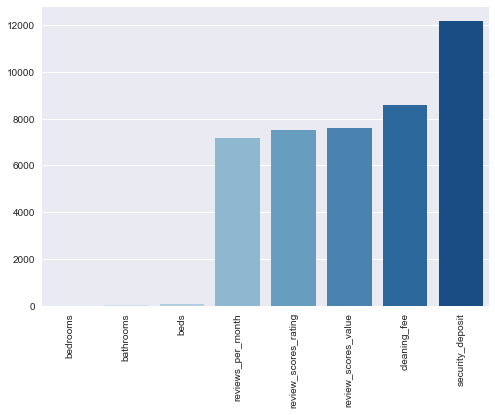

In [130]:
missing  = df.isnull().apply(sum,axis='index')
missing = missing[missing>0]
missing.sort_values(inplace=True)
figure, ax = plt.subplots()
plt.xticks(rotation='90')
sns.barplot(x=missing.index,y=missing,palette='Blues')

#### Strategize and fill the missing values for the numeric. This will play a big hand in determining model accuracy.

Skew for security_depost is: 3.88038354464


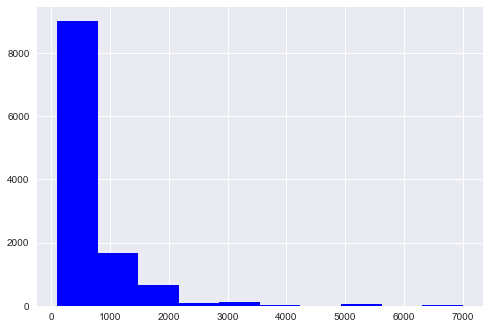

In [131]:
print ("Skew for security_depost is:", df.security_deposit.skew())
plt.hist(df['security_deposit'].dropna(), color='blue')
plt.show()

Skew for cleaning_fee is: 2.2538887073


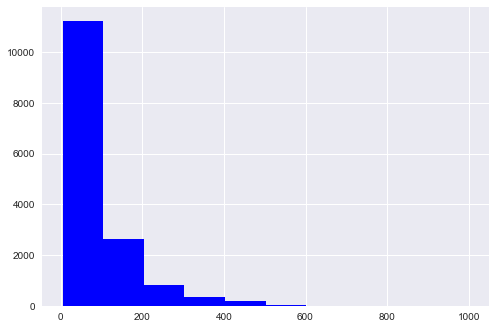

In [132]:
print ("Skew for cleaning_fee is:", df.cleaning_fee.skew())
plt.hist(df['cleaning_fee'].dropna(), color='blue')
plt.show()

Skew for review_scores_value is: 2.2538887073


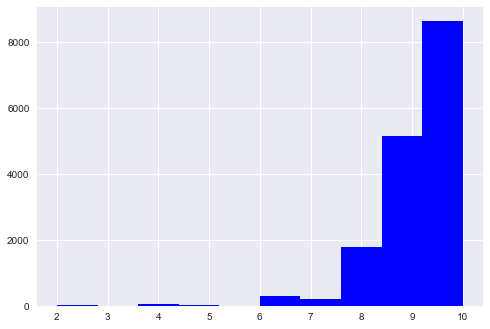

In [133]:
print ("Skew for review_scores_value is:", df.cleaning_fee.skew())
plt.hist(df['review_scores_value'].dropna(), color='blue')
plt.show()

Skew for review_scores_rating is: 2.2538887073


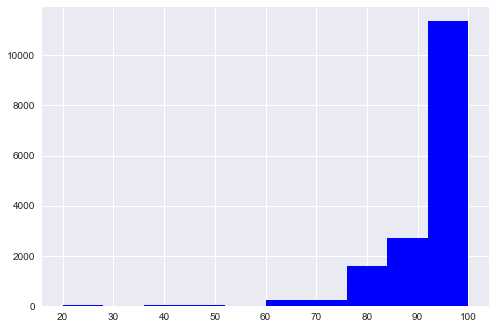

In [134]:
print ("Skew for review_scores_rating is:", df.cleaning_fee.skew())
plt.hist(df['review_scores_rating'].dropna(), color='blue')
plt.show()

Skew for reviews_per_month is: 2.2538887073


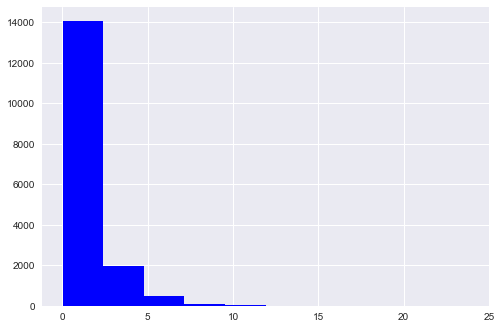

In [135]:
print ("Skew for reviews_per_month is:", df.cleaning_fee.skew())
plt.hist(df['reviews_per_month'].dropna(), color='blue')
plt.show()

Skew for beds is: 2.2538887073


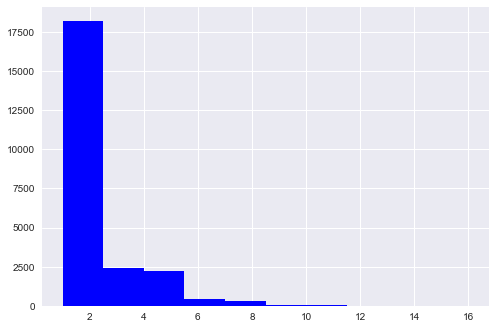

In [136]:
print ("Skew for beds is:", df.cleaning_fee.skew())
plt.hist(df['beds'].dropna(), color='blue')
plt.show()

Skew for bathrooms is: 2.2538887073


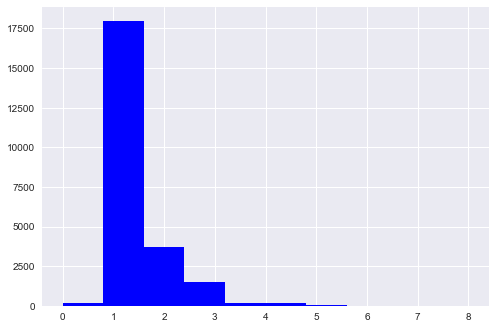

In [137]:
print ("Skew for bathrooms is:", df.cleaning_fee.skew())
plt.hist(df['bathrooms'].dropna(), color='blue')
plt.show()

Skew for bedrooms is: 2.2538887073


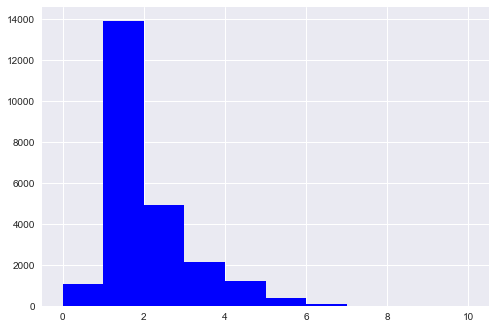

In [138]:
print ("Skew for bedrooms is:", df.cleaning_fee.skew())
plt.hist(df['bedrooms'].dropna(), color='blue')
plt.show()

### From above skewness plot there is either a positive or negative skewness with all the numerical variables that have missing values. Hence filling the missing value with median instead of mean would be a good choice.

In [139]:
df['security_deposit'].fillna(df['security_deposit'].median(), inplace=True)
df['cleaning_fee'].fillna(df['cleaning_fee'].median(), inplace=True)
df['review_scores_value'].fillna(df['review_scores_value'].median(), inplace=True)
df['review_scores_rating'].fillna(df['review_scores_rating'].median(), inplace=True)
df['reviews_per_month'].fillna(df['reviews_per_month'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)

### Scale all the numeric variables by a standar scale.

### Handling missing values for categorical data

In [140]:
categoricals = df.select_dtypes(exclude=[np.number])
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)[:15])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
price,0
cancellation_policy,0
room_type,0
accommodates,0
bathrooms,0
bedrooms,0
beds,0
bed_type,0
security_deposit,0


### Check for the skewness of price to see if a llinear relation would do or should we go for log-linear kind of transformation.

Skew for target attribute is: 14.2487286396


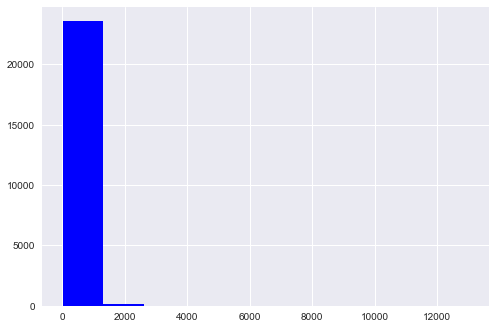

In [141]:
print ("Skew for target attribute is:", df.price.skew())
plt.hist(df.price, color='blue')
plt.show()

Now we use np.log() to transform train.SalePric and calculate the skewness a second time, as well as re-plot the data. A value closer to 0 means that we have improved the skewness of the data. We can see visually that the data will more resembles a normal distribution.

Skew is: 0.614280913091


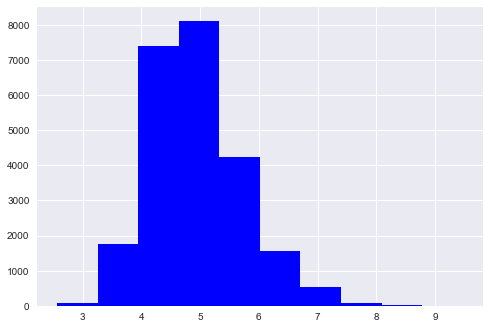

In [142]:
target = np.log(df.price)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

 So in this case, it makes sense to log-transform the target variable

### Well that there are  no missing values left in categorical data. Time to move to split the data into train and test.

In [143]:
if True:
    y = np.log(df.price)
    X = df.drop(['price'], axis=1)
    print('Got executed')

Got executed


### 1. Handle skewness for numerical variables. 2. Handle one-hot encoding for categorical data

In [144]:
# Differentiate numerical features (minus the target) and categorical features

categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns

numerical_features = numerical_features.drop("price")

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

train_num = df[numerical_features]
train_cat = df[categorical_features]

Numerical features : 17
Categorical features : 4


In [145]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed

skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

print(str(skewness.shape[0]) + " skewed numerical features to log transform")

skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

16 skewed numerical features to log transform


C:\Users\ABCD\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [146]:
# create of list of dummy variables that I will drop, which will be the last
# column generated from each categorical feature
dummy_drop = []
for i in train_cat:
    dummy_drop += [ i+'_'+str(train_cat[i].unique()[-1]) ]

print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

# create dummy variables
#df = pd.get_dummies(df,columns=qual)
train_cat = pd.get_dummies(train_cat, columns=train_cat)

# drop the last column generated from each categorical feature
#df = df.drop(dummy_drop,axis=1)
train_cat = train_cat.drop(dummy_drop,axis=1)

print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


In [147]:
# Join categorical and numerical features
df_to_model = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(df_to_model.shape[1]))

New number of features : 52


In [148]:
df_to_model.head()

,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_value,reviews_per_month,calculated_host_listings_count,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,bed_type_Airbed,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_60
0,1.791759,1.098612,1.098612,1.386294,6.216606,4.189655,1.386294,1.791759,0.000000,0.000000,0,0.000000,0.000000,4.574711,2.397895,0.488580,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0
1,1.098612,0.693147,0.000000,0.693147,5.707110,3.583519,0.693147,7.026427,2.397895,3.663562,68,5.075174,2.995732,4.564348,2.302585,1.769855,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,1.791759,0.693147,1.386294,1.609438,6.216606,4.836282,1.098612,7.026427,3.433987,4.110874,90,5.902633,1.609438,4.510860,2.302585,0.615186,1.098612,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,1.098612,1.098612,0.693147,0.693147,6.216606,2.397895,1.098612,7.026427,2.708050,3.806662,74,5.857933,3.178054,4.564348,2.397895,0.641854,1.386294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,2.197225,1.609438,1.609438,1.945910,8.006701,6.216606,1.791759,7.026427,2.484907,2.484907,17,3.332205,0.693147,4.615121,2.197225,0.292670,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


In [149]:
if True:
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df_to_model, y, test_size = 0.33, random_state = 5)

In [150]:
X_train.head()

,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_value,reviews_per_month,calculated_host_listings_count,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,bed_type_Airbed,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_60
8188,1.098612,0.693147,0.693147,0.693147,6.216606,3.931826,1.609438,7.026427,0.0,0.0,0,0.000000,0.000000,4.574711,2.397895,0.488580,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
21533,1.098612,0.693147,0.693147,0.693147,6.216606,4.189655,1.098612,7.026427,0.0,0.0,30,3.465736,1.386294,4.615121,2.397895,0.609766,1.098612,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
13643,1.386294,0.693147,0.693147,1.098612,5.303305,4.615121,1.609438,7.026427,0.0,0.0,0,0.000000,2.397895,4.595120,2.397895,0.506818,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1464,2.397895,1.252763,1.609438,1.945910,6.908755,4.795791,2.708050,5.351858,0.0,0.0,1,1.098612,0.000000,4.574711,2.397895,0.488580,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1290,1.098612,0.693147,0.693147,0.693147,6.216606,4.262680,3.258097,3.828641,0.0,0.0,0,0.000000,0.693147,4.574711,2.397895,0.048790,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


### Standardize numerical features

### The modeling journey start

## KNN regression model

In [151]:
## Vijay - Ran and found the optimum hyperparaamter to be equal to 9, hence commented out.
if False:
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score

    import matplotlib.pyplot as plt
    %matplotlib inline

    hyper_params = [x for x in range(1, 21)]
    mse_values = list()
    rsquared2_values = list()
    train_mse_values =list()

    for hp in hyper_params:
        knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
        knn.fit(X_train, y_train)

        predictions = knn.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_values.append(mse)


        #predictions_train = knn.predict(X_train)
        #mse_train = mean_squared_error(y_train, predictions_train)
        #train_mse_values.append(mse_train)

        rsquared2 = r2_score(y_test, predictions)
        rsquared2_values.append(rsquared2)


    print(mse_values)
    print('\n')
    print(rsquared2_values)

    fig, ax= plt.subplots()
    ax.plot(hyper_params, mse_values, color='#1F77B4', label='Test error')
    #ax.plot(hyper_params, train_mse_values, color='#FF7F0E', label='Train error')
    ax.set_xlabel('Number of neighbours')
    ax.set_ylabel('Test error')
    plt.legend()
    plt.show()

    print('Lowest test error: K = {}'.format(1 + np.argmin(mse_values)))
    #print('Lowest train error: K = {}'.format(1 + np.argmin(train_mse_values)))

In [152]:
## Vijay - Ran and found the CV and test error plot, hence marked under not to run.
if False:
    neighbours=np.arange(1, 21)
    test_rmse = []
    cv_rmse = []
    for k in neighbours: 
        knn = KNeighborsRegressor(n_neighbors= k)  
        scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')    
        rmse = np.sqrt(-1*np.mean(scores)) # taking the average MSE across folds, then taking the square root
        cv_rmse.append(rmse)    

        knn.fit(X_train, y_train)

        predictions = knn.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        test_rmse.append(rmse)

    fig, ax= plt.subplots()
    ax.plot(neighbours, test_rmse, color='#1F77B4', label='Test error')
    ax.plot(neighbours, cv_rmse, color='#FF7F0E', label='CV error')
    ax.set_xlabel('Number of neighbours')
    ax.set_ylabel('RMSE')
    plt.legend()
    plt.show()

    print('Lowest CV error: K = {}'.format(1 + np.argmin(cv_rmse)))   
    print('Lowest test error: K = {}'.format(1 + np.argmin(test_rmse)))

### Find a regression model with Lasso and Ridge

In [153]:
data = pd.concat([df_to_model, y], axis=1)
data.head()

,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_value,reviews_per_month,calculated_host_listings_count,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,bed_type_Airbed,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_60,price
0,1.791759,1.098612,1.098612,1.386294,6.216606,4.189655,1.386294,1.791759,0.000000,0.000000,0,0.000000,0.000000,4.574711,2.397895,0.488580,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,5.023881
1,1.098612,0.693147,0.000000,0.693147,5.707110,3.583519,0.693147,7.026427,2.397895,3.663562,68,5.075174,2.995732,4.564348,2.302585,1.769855,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,4.553877
2,1.791759,0.693147,1.386294,1.609438,6.216606,4.836282,1.098612,7.026427,3.433987,4.110874,90,5.902633,1.609438,4.510860,2.302585,0.615186,1.098612,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,5.703782
3,1.098612,1.098612,0.693147,0.693147,6.216606,2.397895,1.098612,7.026427,2.708050,3.806662,74,5.857933,3.178054,4.564348,2.397895,0.641854,1.386294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,4.317488
4,2.197225,1.609438,1.609438,1.945910,8.006701,6.216606,1.791759,7.026427,2.484907,2.484907,17,3.332205,0.693147,4.615121,2.197225,0.292670,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,6.907755


In [154]:
train = data.sample(frac=0.67, random_state=1)
test = data[data.index.isin(train.index)==False].copy()

In [155]:
response = ['price']
exclude = response
predictors=[x for x in list(data.columns) if x not in exclude]

In [156]:
if False:
    stdSc = StandardScaler()
    X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
    X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [157]:
if False:
    mu = X_train.mean()
    sigma = X_train.std()
    X_train = (X_train - mu) / sigma
    X_test = (X_test - mu) / sigma
    
if True:
    mu=train[predictors].mean()
    sigma=train[predictors].std()
    train[predictors]=(train[predictors]-mu)/sigma
    test[predictors]=(test[predictors]-mu)/sigma

In [158]:
if True:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    print(scaler.fit(X_train))
    X_train = scaler.transform(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [159]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(train[predictors], train[response])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [160]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5)
lasso.fit(train[predictors], np.ravel(train[response])) # the np.ravel is a necessary detail for compatibility

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [161]:
round(np.linalg.norm(lasso.coef_, ord=1)/np.linalg.norm(np.ravel(ols.coef_), ord=1),3)

0.0

In [162]:
pd.DataFrame(lasso.coef_.round(3), index = predictors).T

,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_value,reviews_per_month,calculated_host_listings_count,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,bed_type_Airbed,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_60
0,0.21,0.082,0.112,-0.019,0.073,0.098,-0.021,-0.002,0.078,-0.098,0.088,0.004,-0.048,0.065,-0.04,-0.001,-0.012,-0.0,0.017,0.021,-0.0,-0.004,0.004,-0.012,0.005,0.001,0.002,-0.007,-0.003,0.004,0.005,0.003,-0.0,0.004,-0.013,0.002,-0.001,0.0,-0.002,-0.013,-0.001,-0.001,0.571,0.293,0.009,-0.0,-0.003,0.0,-0.005,-0.0,0.028,0.012


In [163]:
from sklearn.linear_model import RidgeCV

alphas = np.exp(np.linspace(-10,20,500)) 
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(train[predictors], np.ravel(train[response]))

RidgeCV(alphas=array([  4.53999e-05,   4.82131e-05, ...,   4.56856e+08,   4.85165e+08]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [164]:
print(round(np.linalg.norm(ridge.coef_)/np.linalg.norm(np.ravel(ols.coef_)), 3))

0.0


In [165]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=ridge.alpha_)
ridge.fit(train[predictors], np.ravel(train[response]))

Ridge(alpha=4.5399929762484854e-05, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [166]:
knn_9 = KNeighborsRegressor(n_neighbors=9, algorithm='brute', 
                            metric_params={'V': train[predictors].cov()})
knn_9.fit(train[predictors], np.ravel(train[response]))

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params={'V':                                      accommodates  bathrooms  bedrooms  \
accommodates                             1.000000   0.545638  0.751442
bathrooms                                0.545638   1.000000  0.580905
bedrooms                                 0.751442   0.5809...             -0.041606
cancellation_policy_super_strict_60                             1.000000  },
          n_jobs=1, n_neighbors=9, p=2, weights='uniform')

## Cross validation for Regression models

In [167]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Cross validator
kf=KFold(10, shuffle=True, random_state=1) 

# Methods
columns = ['CV RMSE']
rows = ['OLS', 'Ridge','Lasso', 'knn']

regressions = [ols, ridge, lasso, knn_9]
results = pd.DataFrame(0.0, columns=columns, index=rows) # initialising a dataframe to hold the results

methods = {k: v for k, v in zip(rows, regressions)}

# Computing the results (Scikit Learn objects)
keys = ['OLS', 'Ridge', 'Lasso', 'knn']
for key in keys:
    scores = cross_val_score(methods[key], train[predictors], np.ravel(train[response]), cv=kf, 
                             scoring = 'neg_mean_squared_error')
    results.loc[key] = np.sqrt(-1*np.mean(scores))
    
results.round(3)

,CV RMSE
OLS,5.141226e+09
Ridge,4.280000e-01
Lasso,4.280000e-01
knn,4.410000e-01


In [168]:
columns=['Test RMSE', 'SE', 'Test R2', 'SE']
rows=['OLS', 'Ridge', 'Lasso', 'knn']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

# from now on, we use the Jackknife method to be able to report the standard errors for the test results
from statlearning import rmse_jack, r2_jack 

methods=[ols, ridge, lasso, knn]
i=0
for method in methods:
    pred=method.predict(test[predictors])
    results.iloc[i,0], results.iloc[i,1] = rmse_jack(test[response], pred)
    results.iloc[i,2], results.iloc[i,3] = r2_jack(test[response], pred)
    i+=1

results.round(3)

,Test RMSE,SE,Test R2,SE
OLS,4.202654e+09,4.202386e+09,-2.935395e+19,2.935872e+19
Ridge,4.260000e-01,6.000000e-03,6.980000e-01,8.000000e-03
Lasso,4.260000e-01,6.000000e-03,6.990000e-01,8.000000e-03
knn,8.850000e-01,8.000000e-03,-3.030000e-01,1.700000e-02


### R2 values for the lasso and OLS model

In [169]:
print ("R^2 for OLS train is: \n", ols.score(train[predictors], train[response]))

R^2 for OLS train is: 
 0.70248291314


In [170]:
print ("R^2 for OLS test is: \n", ols.score(test[predictors], test[response]))

R^2 for OLS test is: 
 -2.93539457508e+19


In [171]:
print ("R^2 for lasso train is: \n", lasso.score(train[predictors], train[response]))
print ("R^2 for lasso test is: \n", lasso.score(test[predictors], test[response]))

R^2 for lasso train is: 
 0.702121569294
R^2 for lasso test is: 
 0.698614115168


### p-values for Null hypothesis study

In [172]:
## Some of the atributes are dropped as their names contain spaces and speciaal characters. They are close to 5 in number and 
## will not impact the hypothesis conclusion.

import statsmodels.formula.api as smf

formula='price ~ accommodates + bathrooms + bedrooms + beds + security_deposit + cleaning_fee + minimum_nights + \
maximum_nights + bathrooms + availability_30 + availability_60 + availability_90 + availability_365 + number_of_reviews + \
review_scores_rating + review_scores_value + reviews_per_month  + calculated_host_listings_count + property_type_Apartment + \
property_type_Boat + property_type_Bungalow + property_type_Cabin + property_type_Castle + property_type_Chalet + \
property_type_Condominium + property_type_Dorm + property_type_Guesthouse + property_type_Hostel +  property_type_House + \
property_type_Hut + property_type_Loft +  property_type_Other + property_type_Tent + property_type_Timeshare + \
property_type_Tipi + property_type_Townhouse + property_type_Treehouse + property_type_Villa + \
bed_type_Airbed + bed_type_Futon + cancellation_policy_flexible + cancellation_policy_moderate + cancellation_policy_strict + \
cancellation_policy_super_strict_60'

ols = smf.ols(formula=formula, data=data).fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     944.2
Date:                Mon, 23 Oct 2017   Prob (F-statistic):               0.00
Time:                        17:40:47   Log-Likelihood:                -15935.
No. Observations:               23778   AIC:                         3.196e+04
Df Residuals:                   23734   BIC:                         3.231e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

#### Residual plotting for train and test

Residual plot for training data (blue) and test data (orange) below


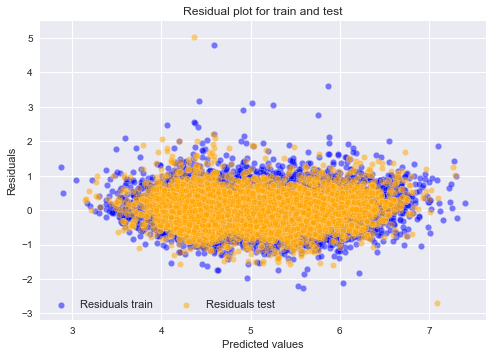

In [173]:
actual_values_train = np.ravel(train[response])
predictions_train = lasso.predict(train[predictors])
residuals_train = actual_values_train - predictions_train

actual_values_test = np.ravel(test[response])
predictions_test = lasso.predict(test[predictors])
residuals_test = actual_values_test - predictions_test

print('Residual plot for training data (blue) and test data (orange) below')

_train = plt.scatter(predictions_train, residuals_train, c='blue', s=40, alpha=0.5, edgecolor='white')
_test = plt.scatter(predictions_test, residuals_test, c='orange', s=40, alpha=0.5, edgecolor='white')

plt.legend((_train, _test),
           ('Residuals train', 'Residuals test'),
           loc='lower left',
           ncol=3,
           fontsize=11)

_ = plt.ylabel('Residuals')
_ = plt.xlabel('Predicted values')
_ = plt.title('Residual plot for train and test')